In [1]:
# device.py
import torch

try:
    import torch_directml
    device = torch_directml.device()
    print("Using AMD DirectML GPU")
except:
    device = torch.device("cpu")
    print("Using CPU")


Using AMD DirectML GPU


## CLASSIFICATION MODEL - WEEK 1

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch_directml

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

device = torch_directml.device()
print("Using device:", device)


Using device: privateuseone:0


In [3]:
metadata_path = "archive/HAM10000_metadata.csv"
df = pd.read_csv(metadata_path)

print("Total Images:", len(df))
df.head()


Total Images: 10015


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


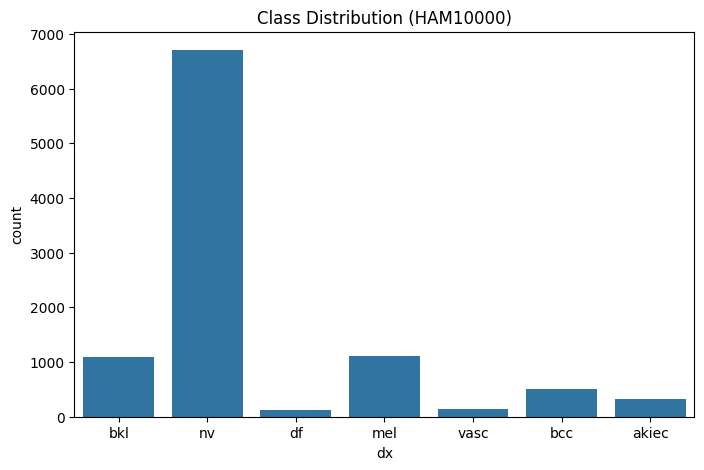

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


In [4]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="dx")
plt.title("Class Distribution (HAM10000)")
plt.show()

print(df["dx"].value_counts())


In [5]:
train_df, temp_df = train_test_split(
    df, test_size=0.3, stratify=df["dx"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["dx"], random_state=42
)

print("Train:", len(train_df))
print("Val:", len(val_df))
print("Test:", len(test_df))


Train: 7010
Val: 1502
Test: 1503


In [6]:
img_part1 = "archive/HAM10000_images_part_1"
img_part2 = "archive/HAM10000_images_part_2"

output_dir = "data/classification"

import shutil

def move_images(dataframe, split):
    for _, row in dataframe.iterrows():
        label = row["dx"]
        img_name = row["image_id"] + ".jpg"

        src1 = os.path.join(img_part1, img_name)
        src2 = os.path.join(img_part2, img_name)

        src = src1 if os.path.exists(src1) else src2

        dest_dir = os.path.join(output_dir, split, label)
        os.makedirs(dest_dir, exist_ok=True)

        shutil.copy(src, os.path.join(dest_dir, img_name))

move_images(train_df, "train")
move_images(val_df, "val")
move_images(test_df, "test")

print("Dataset structured successfully.")


Dataset structured successfully.


In [25]:
transform = transforms.Compose([
    transforms.Resize((240,240)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder("data/classification/train", transform)
val_dataset   = datasets.ImageFolder("data/classification/val", transform)
test_dataset  = datasets.ImageFolder("data/classification/test", transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16)
test_loader  = DataLoader(test_dataset, batch_size=16)

print("Classes:", train_dataset.classes)


Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [26]:
model = models.resnet18(weights="DEFAULT")
model.fc = nn.Linear(model.fc.in_features, 7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [27]:
for epoch in range(5):
    model.train()
    total_loss = 0

    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

model_dir = "models_2"
os.makedirs(model_dir, exist_ok=True)
torch.save(model.state_dict(), os.path.join(model_dir, "resnet18_baseline.pt"))
print("Saved baseline model to models/resnet18_baseline.pt")

100%|██████████| 439/439 [08:21<00:00,  1.14s/it]


Epoch 1, Loss: 296.1993


100%|██████████| 439/439 [08:17<00:00,  1.13s/it]


Epoch 2, Loss: 172.2154


100%|██████████| 439/439 [08:24<00:00,  1.15s/it]


Epoch 3, Loss: 101.0550


100%|██████████| 439/439 [08:28<00:00,  1.16s/it]


Epoch 4, Loss: 64.0995


100%|██████████| 439/439 [08:03<00:00,  1.10s/it]


Epoch 5, Loss: 43.8561
Saved baseline model to models/resnet18_baseline.pt


In [28]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        
        y_pred.extend(preds)
        y_true.extend(labels.numpy())

print("=== Baseline Classification Report ===")
print(classification_report(y_true, y_pred, target_names=train_dataset.classes))


=== Baseline Classification Report ===
              precision    recall  f1-score   support

       akiec       0.59      0.78      0.67        49
         bcc       0.87      0.61      0.72        77
         bkl       0.83      0.63      0.72       165
          df       0.69      0.53      0.60        17
         mel       0.73      0.57      0.64       167
          nv       0.88      0.97      0.92      1006
        vasc       1.00      0.59      0.74        22

    accuracy                           0.85      1503
   macro avg       0.80      0.67      0.72      1503
weighted avg       0.85      0.85      0.84      1503



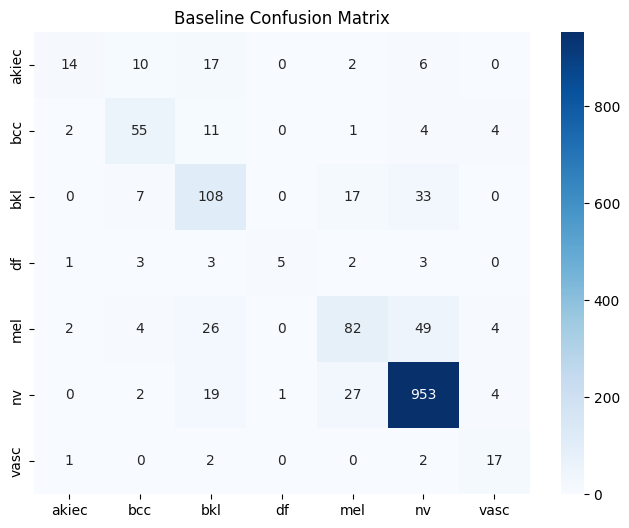

In [11]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=train_dataset.classes,
            yticklabels=train_dataset.classes,
            cmap="Blues")

plt.title("Baseline Confusion Matrix")
plt.show()


In [29]:
misclassified = np.array(y_true) != np.array(y_pred)
print("Total Misclassified:", misclassified.sum())

for i, class_name in enumerate(train_dataset.classes):
    class_indices = np.array(y_true) == i
    class_mis = misclassified & class_indices
    print(f"{class_name} misclassified:", class_mis.sum())


Total Misclassified: 226
akiec misclassified: 11
bcc misclassified: 30
bkl misclassified: 61
df misclassified: 8
mel misclassified: 72
nv misclassified: 35
vasc misclassified: 9


## BRIGHTNESS

In [30]:
transform_bright = transforms.Compose([
    transforms.Resize((240,240)),
    transforms.ColorJitter(brightness=0.5),
    transforms.ToTensor()
])

train_dataset_b = datasets.ImageFolder("data/classification/train", transform_bright)
test_dataset_b  = datasets.ImageFolder("data/classification/test", transform_bright)

train_loader_b = DataLoader(train_dataset_b, batch_size=16, shuffle=True)
test_loader_b  = DataLoader(test_dataset_b, batch_size=16)


In [31]:
model_b = models.resnet18(weights="DEFAULT")
model_b.fc = nn.Linear(model_b.fc.in_features, 7)
model_b = model_b.to(device)

criterion_b = nn.CrossEntropyLoss()
optimizer_b = optim.Adam(model_b.parameters(), lr=1e-4)

for epoch in range(5):
    model_b.train()
    total_loss = 0

    for images, labels in tqdm(train_loader_b):
        images = images.to(device)
        labels = labels.to(device)

        optimizer_b.zero_grad()
        outputs = model_b(images)
        loss = criterion_b(outputs, labels)
        loss.backward()
        optimizer_b.step()

        total_loss += loss.item()

    print(f"[Brightness] Epoch {epoch+1}, Loss: {total_loss:.4f}")

model_dir = "models"
os.makedirs(model_dir, exist_ok=True)
torch.save(model_b.state_dict(), os.path.join(model_dir, "resnet18_brightness.pt"))
print("Saved brightness model to models/resnet18_brightness.pt")

100%|██████████| 439/439 [08:01<00:00,  1.10s/it]


[Brightness] Epoch 1, Loss: 326.1975


100%|██████████| 439/439 [07:58<00:00,  1.09s/it]


[Brightness] Epoch 2, Loss: 208.0379


100%|██████████| 439/439 [08:08<00:00,  1.11s/it]


[Brightness] Epoch 3, Loss: 144.8557


100%|██████████| 439/439 [10:34<00:00,  1.45s/it]


[Brightness] Epoch 4, Loss: 85.3233


100%|██████████| 439/439 [09:45<00:00,  1.33s/it]


[Brightness] Epoch 5, Loss: 54.4927
Saved brightness model to models/resnet18_brightness.pt


In [20]:
model_b.eval()
y_true_b = []
y_pred_b = []

with torch.no_grad():
    for images, labels in test_loader_b:
        images = images.to(device)
        outputs = model_b(images)
        preds = outputs.argmax(1).cpu().numpy()
        
        y_pred_b.extend(preds)
        y_true_b.extend(labels.numpy())

print("=== Brightness Model Classification Report ===")
print(classification_report(y_true_b, y_pred_b, target_names=train_dataset.classes))


=== Brightness Model Classification Report ===
              precision    recall  f1-score   support

       akiec       0.48      0.55      0.51        49
         bcc       0.76      0.44      0.56        77
         bkl       0.62      0.75      0.68       165
          df       0.43      0.35      0.39        17
         mel       0.78      0.37      0.50       167
          nv       0.89      0.96      0.92      1006
        vasc       0.77      0.77      0.77        22

    accuracy                           0.82      1503
   macro avg       0.67      0.60      0.62      1503
weighted avg       0.82      0.82      0.81      1503



In [23]:
print("Baseline Accuracy:", np.mean(np.array(y_true)==np.array(y_pred)))
print("Brightness Accuracy:", np.mean(np.array(y_true_b)==np.array(y_pred_b)))



Baseline Accuracy: 0.8210246174318031
Brightness Accuracy: 0.8216899534264803


In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

baseline_metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision (macro)": precision_score(y_true, y_pred, average="macro"),
    "Recall (macro)": recall_score(y_true, y_pred, average="macro"),
    "F1-score (macro)": f1_score(y_true, y_pred, average="macro"),
}

brightness_metrics = {
    "Accuracy": accuracy_score(y_true_b, y_pred_b),
    "Precision (macro)": precision_score(y_true_b, y_pred_b, average="macro"),
    "Recall (macro)": recall_score(y_true_b, y_pred_b, average="macro"),
    "F1-score (macro)": f1_score(y_true_b, y_pred_b, average="macro"),
}

comparison_df = pd.DataFrame(
    [baseline_metrics, brightness_metrics],
    index=["Baseline", "Brightness"]
)

comparison_df


,Accuracy,Precision (macro),Recall (macro),F1-score (macro)
Baseline,0.821025,0.701824,0.594246,0.613745
Brightness,0.821690,0.674725,0.599314,0.619119
